In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import glob
import os   
import matplotlib as mpl
from itertools import cycle

from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
from matplotlib.cm import viridis
from scipy import interpolate
from collections import Counter

from scipy.interpolate import interp1d, UnivariateSpline

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatRangeSlider
import pandas as pd
import matplotlib.ticker as ticker
from ipywidgets import interact, FloatRangeSlider
from ipywidgets import interactive

import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interactive, VBox
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns


In [16]:
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FormatStrFormatter,MaxNLocator
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import LogLocator

mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.size'] = 3
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.minor.size'] = 1.5
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 3
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.minor.size'] = 1.5
mpl.rcParams['ytick.minor.width'] = 0.5

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.serif'] = 'Arial'

In [17]:
experiments = ['23.11.14-15', '23.12.22-23', '24.04.01', '24.07.08', '24.11.09', '24.11.14']
old_exp = ['23.11.14-15', '23.12.22-23', '24.04.01', '24.07.08']
asymptotic_exp = ['24.11.09', '24.11.14']

In [18]:
df_list = []
particle_offset = 0
exp_loc_dist = {}

for exp in experiments[:]:
    df = pd.read_csv(f'combined_output_{exp}_manual_vcheck.csv')

    df['particle'] += particle_offset
    particle_offset += df['particle'].max() + 1
    exp_loc_dist[exp] = df['f_location'].unique().tolist()
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

# change particle ID since the original are arbitraty
unique_particles = sorted(combined_df['particle'].unique())
particle_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_particles)}

# Map the 'particle' column to new IDs based on the mapping
combined_df['particle'] = combined_df['particle'].map(particle_mapping)

combined_df['particle'].unique().shape


(832,)

In [19]:
df_list = []
particle_offset = 0
exp_loc_dist = {}

for exp in experiments[:]:
    df = pd.read_csv(f'combined_output_{exp}_manual_vcheck.csv')

    df['particle'] += particle_offset
    particle_offset += df['particle'].max() + 1
    exp_loc_dist[exp] = df['f_location'].unique().tolist()
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

# change particle ID since the original are arbitraty
unique_particles = sorted(combined_df['particle'].unique())
particle_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_particles)}

# Map the 'particle' column to new IDs based on the mapping
combined_df['particle'] = combined_df['particle'].map(particle_mapping)

combined_df['particle'].unique().shape

(832,)

In [20]:
combined_df['radius'].max()

18.79364572

In [21]:
reference_pH = 8.5          # used for the calculation of radius and rates
min_radius = 3.4            # minimum droplet size used in the analysis
target_pH = 7.5             # droplets which don't form vacuoles are tracked till this pH

radius_at_ref_pH = []       # radius at ref pH
t0_at_ref_pH = []           # time when the droplet crosses ref pH

ph_vfirst = []              # pH of vacuole formation
initial_pH = []             # inital reported pH for droplets
vacuole = []                # 0 or 1, if the droplet forms vacuoles or not
initial_radius = []         # initial reported radius
particle_IDs = []       
reaches_target_pH = []      # 0 or 1, if the droplet reaches the target pH
consider_drop = []      
# droplets which form vacuoles -> consider all for analysis
# droplets which don't form vacuoles -> only consider droplets which reach the target pH
min_pH = []             # minimum pH

for particle_ID in combined_df['particle'].unique():

    particle_IDs.append(particle_ID)
    
    data = combined_df[combined_df['particle']==particle_ID]
    
    ph_vfirst.append(data['pH_vfirst'].values[0])
    initial_pH.append(data['pH'].values[0])
    initial_radius.append(data['radius'].values[0])
    vacuole.append(data['vacuole'].values[0])
    min_pH.append(data['pH'].min())

    if data['exp_date'].values[0] in asymptotic_exp:
        consider_drop.append(1)
    else:
        if data['pH'].min()>target_pH:
            reaches_target_pH.append(0)
        else:
            reaches_target_pH.append(1)

        if (vacuole[-1]==0) and (reaches_target_pH[-1]==0):
            consider_drop.append(0)
        elif (vacuole[-1]==0.5):
            consider_drop.append(0)
        else:
            consider_drop.append(1)
        
    f_inverse = interp1d(data['pH'], data['time(sec)'], kind='linear', bounds_error=False, fill_value=np.nan)
    t0 = f_inverse(reference_pH)

    if np.isnan(t0):
        radius_at_ref_pH.append(np.nan)
    else:
        radius_interp = interp1d(data['time(sec)'], data['radius'], kind='linear', bounds_error=False, fill_value=np.nan)
        rad = radius_interp(t0)
        radius_at_ref_pH.append(rad)

    t0_at_ref_pH.append(t0)

radius_at_ref_pH = np.array(radius_at_ref_pH).ravel()
t0_at_ref_pH = np.array(t0_at_ref_pH).ravel()
vacuole = np.array(vacuole)
consider_drop = np.array(consider_drop)

In [22]:
radius_ref_pH_dict = dict(zip(particle_IDs, radius_at_ref_pH))
t0_ref_pH_dict = dict(zip(particle_IDs, t0_at_ref_pH))
consider_dict = dict(zip(particle_IDs, consider_drop))
min_pH_dict = dict(zip(particle_IDs, min_pH))

combined_df['radius_ref_pH'] = combined_df['particle'].map(radius_ref_pH_dict)
combined_df['t0_ref_pH'] = combined_df['particle'].map(t0_ref_pH_dict)
combined_df['consider_drop'] = combined_df['particle'].map(consider_dict)
combined_df['min_pH'] = combined_df['particle'].map(min_pH_dict)

# defining pH_sigma as the symmetric uncertainity in the pH values. 
# using the geometric mean of the 2 uncertainities
combined_df['pH_sigma'] = ((combined_df['pHhigh']-combined_df['pH'])*(combined_df['pH']-combined_df['pHlow']))**0.5

In [23]:

norm = Normalize(vmin=3.4, vmax=12)
cmap = plt.cm.viridis

# Function to plot filtered data
def plot_filtered_data(exp_1, exp_2, exp_3, exp_4, exp_5, exp_6):
    selected_experiments = [
        exp for exp, is_on in zip(experiments, [exp_1, exp_2, exp_3, exp_4, exp_5, exp_6]) if is_on
    ]
    
    # Filter data based on selected experiments
    filtered_data = combined_df[combined_df['exp_date'].isin(selected_experiments)]
    
    # Clear previous plots
    plt.figure(figsize=(10, 6))
    
    # Plot lines for each particle in the filtered data
    for particle_ID in filtered_data['particle'].unique():
        data = filtered_data[filtered_data['particle'] == particle_ID]
        color = cmap(norm(data['radius_ref_pH'].values[0]))
        if data['vacuole'].values[0] == 0:
            plt.plot(data['time(sec)'] - data['time(sec)'].values[0], data['pH'], color=color, alpha=0.5)
        if data['vacuole'].values[0] == 1:
            plt.plot(data['time(sec)'] - data['time(sec)'].values[0], data['pH'], 'o', fillstyle='none', color=color, alpha=0.5)
    
    # Label axes
    plt.xlabel('Time (sec)')
    plt.ylabel('pH')
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Radius')
    
    # Set y-axis limits
    plt.ylim([7, 10])
    # plt.semilogx()
    
    # Show plot
    plt.show()

# Create interactive toggle buttons for each experiment
toggle_buttons = {
    exp: widgets.ToggleButton(
        value=True,  # Start with all switches ON
        description=exp,
        button_style='success',  # Green color for ON
        layout=widgets.Layout(width='120px')
    ) for exp in experiments
}

# Create interactive plot using the toggle buttons
interactive_plot = interactive(
    plot_filtered_data,
    exp_1=toggle_buttons[experiments[0]],
    exp_2=toggle_buttons[experiments[1]],
    exp_3=toggle_buttons[experiments[2]],
    exp_4=toggle_buttons[experiments[3]],
    exp_5=toggle_buttons[experiments[4]],
    exp_6=toggle_buttons[experiments[5]]
)

# Display the interactive plot
interactive_plot

interactive(children=(ToggleButton(value=True, button_style='success', description='23.11.14-15', layout=Layou…

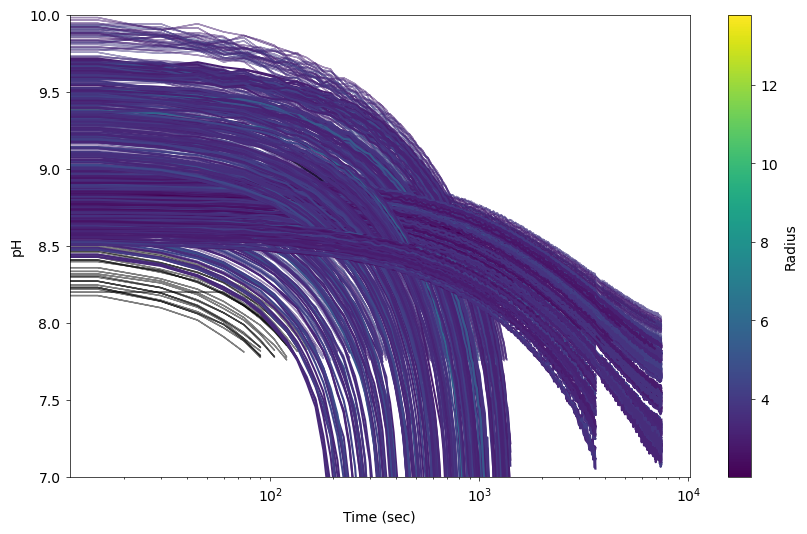

In [24]:

norm = Normalize(vmin=combined_df['radius_ref_pH'].min(), vmax=combined_df['radius_ref_pH'].max())
cmap = plt.cm.viridis


selected_experiments = [experiments[0]]
filtered_data = combined_df[combined_df['exp_date'].isin(selected_experiments)]

# Clear previous plots
plt.figure(figsize=(10, 6))

# Plot lines for each particle in the filtered data
for particle_ID in filtered_data['particle'].unique():
    data = filtered_data[filtered_data['particle'] == particle_ID]
    color = cmap(norm(data['radius_ref_pH'].values[0]))
    plt.plot(data['time(sec)'] - data['time(sec)'].values[0], data['pH'], color=color)
    plt.fill_between(data['time(sec)'] - data['time(sec)'].values[0], data['pHhigh'], data['pHhigh'], color=color, alpha=0.5)

# plt.xlim(right=31000)

# Label axes
plt.xlabel('Time (sec)')
plt.ylabel('pH')

# Add color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Radius')

# Set y-axis limits
plt.ylim([7, 10])
plt.semilogx()

# Show plot
plt.show()



/tmp/ipykernel_13006/3219159985.py:18: RuntimeWarning: invalid value encountered in scalar divide
  rate_param = (data['pH'].iloc[-1] - data['pH'].iloc[0]) / (data['time(sec)'].iloc[-1] - data['time(sec)'].iloc[0])


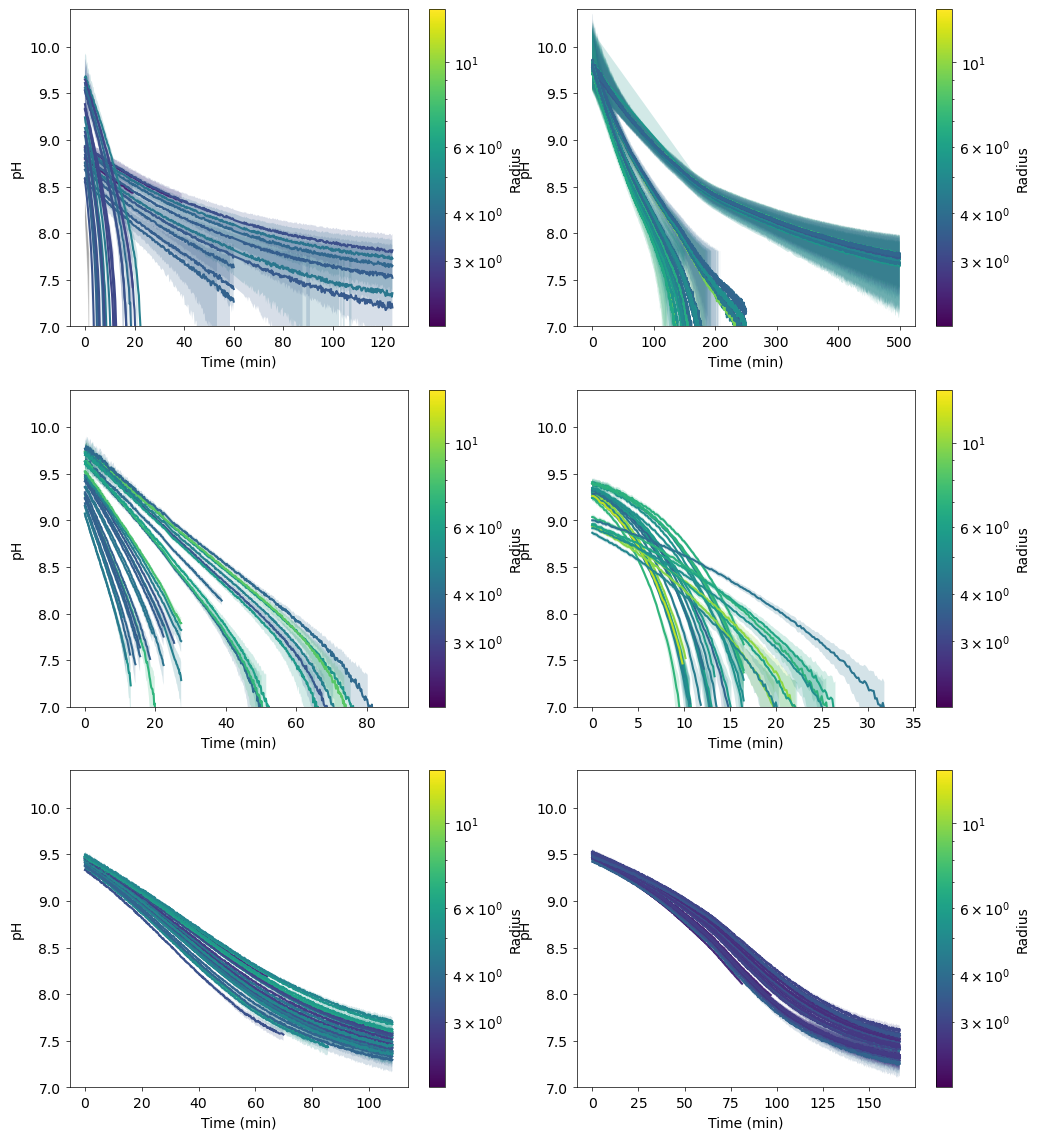

In [25]:

# Use LogNorm for color normalization
norm = LogNorm(vmin=combined_df['radius_ref_pH'].min(), vmax=combined_df['radius_ref_pH'].max())
cmap = plt.cm.viridis

# Create a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))  # Adjust the figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for idx, exp in enumerate(experiments):

    selected_experiments = [exp]
    filtered_data = combined_df[combined_df['exp_date'].isin(selected_experiments)]


    rate_parameters = {}
    for particle_ID in filtered_data['particle'].unique():
        data = filtered_data[filtered_data['particle'] == particle_ID]
        rate_param = (data['pH'].iloc[-1] - data['pH'].iloc[0]) / (data['time(sec)'].iloc[-1] - data['time(sec)'].iloc[0])
        rate_parameters[particle_ID] = rate_param

    # Convert rate parameters to a DataFrame for sorting
    rate_df = pd.DataFrame({
        'particle': list(rate_parameters.keys()),
        'rate_parameter': list(rate_parameters.values())
    })

    # Sort by rate_parameter
    rate_df = rate_df.sort_values(by='rate_parameter').reset_index(drop=True)

    # Select every nth particle to get 20 trajectories
    n = max(1, len(rate_df) // 30)  # Ensure we get approximately 20 lines
    selected_particles = rate_df.iloc[1::n]['particle'].values

    # Filter data for selected particles
    selected_data = filtered_data[filtered_data['particle'].isin(selected_particles)]

    ax = axes[idx]

    # Plot lines for the selected particles
    for particle_ID in selected_particles:
        data = selected_data[selected_data['particle'] == particle_ID]
        color = cmap(norm(data['radius_ref_pH'].values[0]))
        time_min = (data['time(sec)'] - data['time(sec)'].values[0])/60
        ax.fill_between(time_min, data['pHhigh'], data['pHlow'], color=color, alpha=0.2, ec='none')
        ax.plot(time_min, data['pH'], color=color, label=f'Particle {particle_ID}')

    # Label axes
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('pH')
    ax.set_ylim([7,10.4])
    # ax.set_xlim(right=510)

    # Add color bar with LogNorm
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Radius')



364
[np.int64(319), np.int64(347), np.int64(342), np.int64(345), np.int64(326), np.int64(327), np.int64(356), np.int64(355), np.int64(182), np.int64(360), np.int64(336), np.int64(351), np.int64(361), np.int64(352), np.int64(172), np.int64(161), np.int64(203), np.int64(207), np.int64(159), np.int64(214), np.int64(148), np.int64(153), np.int64(188), np.int64(173), np.int64(183), np.int64(187), np.int64(192), np.int64(154), np.int64(213), np.int64(168), np.int64(211), np.int64(234), np.int64(206), np.int64(239), np.int64(229), np.int64(197), np.int64(201), np.int64(237), np.int64(227), np.int64(228)]
39
[np.int64(399), np.int64(395), np.int64(394), np.int64(401), np.int64(398), np.int64(400), np.int64(402), np.int64(397), np.int64(373), np.int64(377), np.int64(381), np.int64(372), np.int64(374), np.int64(376), np.int64(382), np.int64(378), np.int64(380), np.int64(375), np.int64(370), np.int64(371), np.int64(379)]
139
[np.int64(474), np.int64(454), np.int64(492), np.int64(470), np.int64(47

/tmp/ipykernel_13006/983335958.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


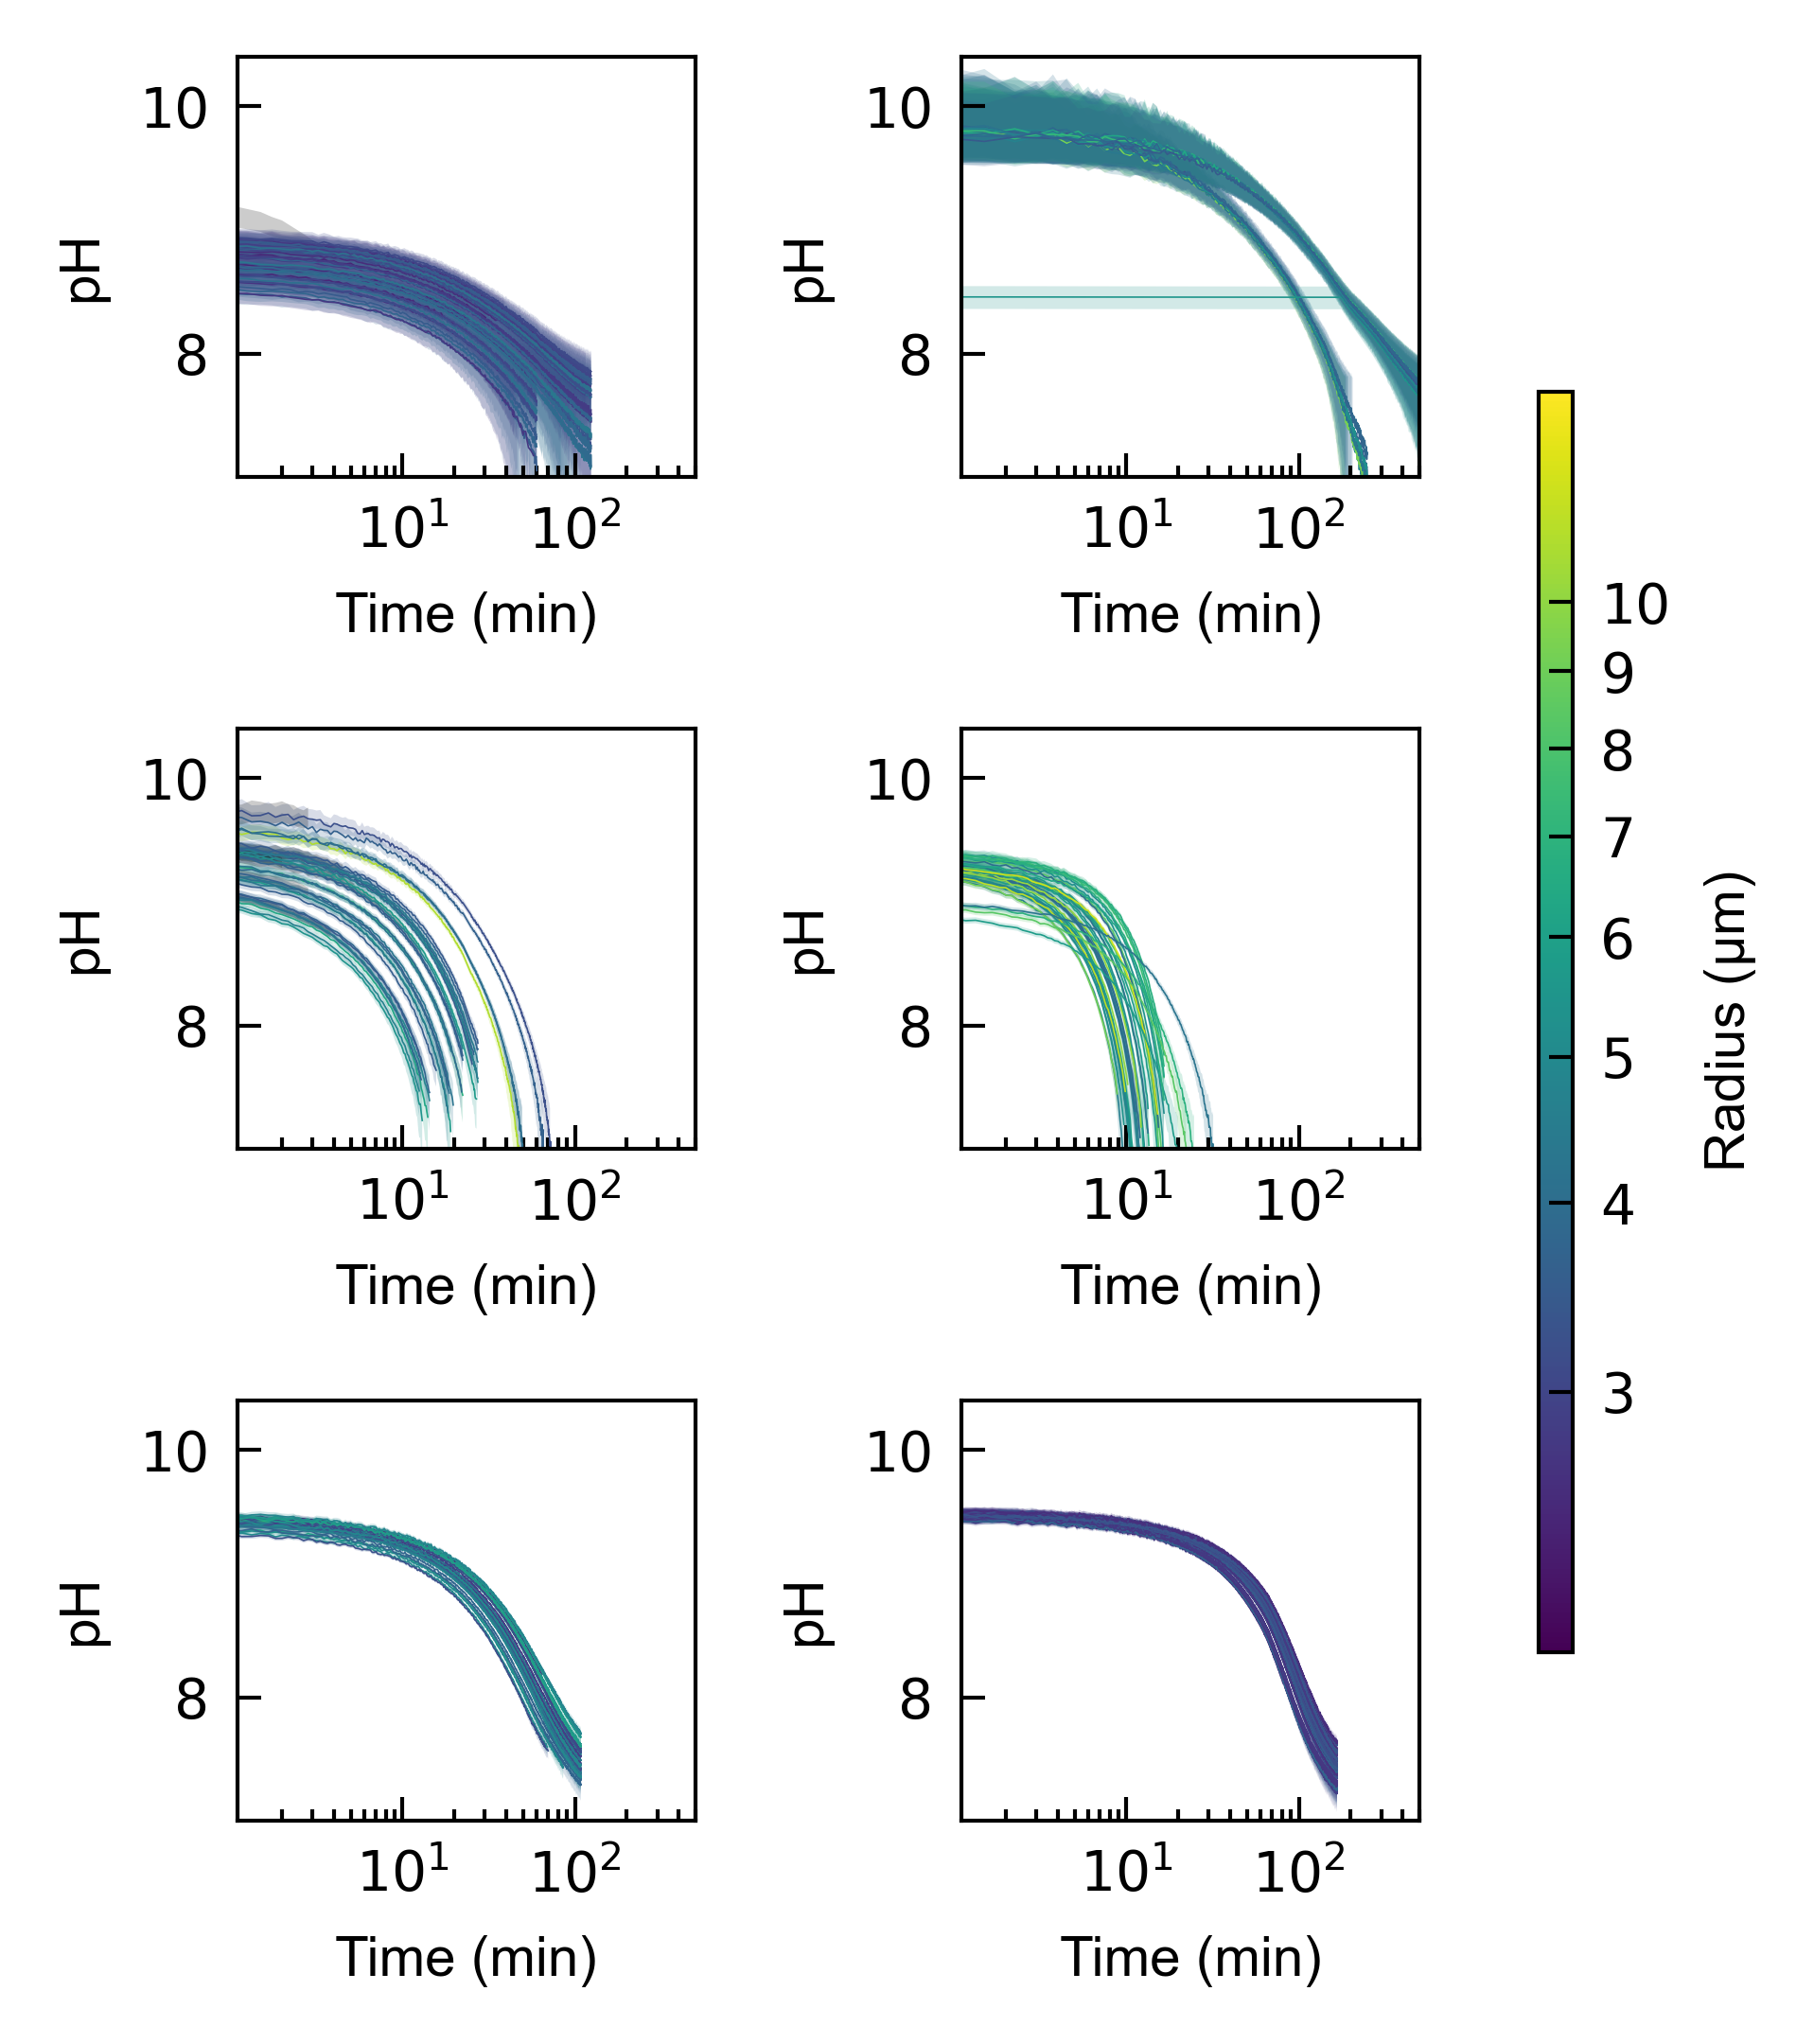

In [26]:
fixed_width = 3
tentative_height = 1.1*3 + 0.2*2

# Use LogNorm for color normalization
norm = LogNorm(vmin=combined_df['radius_ref_pH'].min(), vmax=combined_df['radius_ref_pH'].max())
cmap = plt.cm.viridis

# Create a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(fixed_width, tentative_height), dpi=600)  # Adjust the figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for idx, exp in enumerate(experiments):
    selected_experiments = [exp]
    filtered_data = combined_df[combined_df['exp_date'].isin(selected_experiments)]

    rate_parameters = {}
    for particle_ID in filtered_data['particle'].unique():
        data = filtered_data[filtered_data['particle'] == particle_ID]

        # Ensure data is not empty before computing the rate parameter
        if not data.empty and len(data) > 1:  # Need at least two points to compute rate
            rate_param = (data['pH'].iloc[-1] - data['pH'].iloc[0]) / (data['time(sec)'].iloc[-1] - data['time(sec)'].iloc[0])
            
            # Ensure rate_param is finite before adding to dictionary
            if np.isfinite(rate_param):
                rate_parameters[particle_ID] = rate_param

    print(len(filtered_data['particle'].unique()))

    # Convert rate parameters to a DataFrame for sorting
    rate_df = pd.DataFrame({
        'particle': list(rate_parameters.keys()),
        'rate_parameter': list(rate_parameters.values())
    })

    # Sort by rate_parameter
    rate_df = rate_df.sort_values(by='rate_parameter').reset_index(drop=True)

    # Bin the rate parameters into 10 groups
    rate_df['bin'] = pd.qcut(rate_df['rate_parameter'], q=40, labels=False, duplicates='drop')


    valid_particles = []
    for bin_id, group in rate_df.groupby('bin'):
        # Filter out particles with fewer than 10 datapoints
        eligible_particles = group['particle'][group['particle'].map(lambda p: len(filtered_data[filtered_data['particle'] == p]) >= 10)]
        
        if not eligible_particles.empty:  # Ensure there are valid candidates in this bin
            valid_particles.append(eligible_particles.sample(n=1, random_state=14).values[0])

    # Filter data for selected particles
    selected_data = filtered_data[filtered_data['particle'].isin(valid_particles)]

    print(valid_particles)
    ax = axes[idx]

    # Plot lines for the selected particles
    for particle_ID in valid_particles:
        data = selected_data[selected_data['particle'] == particle_ID]
        color = cmap(norm(data['radius_ref_pH'].values[0]))
        time_min = (data['time(sec)'] - data['time(sec)'].values[0]) / 60
        if idx==1:
            ax.fill_between(time_min.iloc[::3], data['pHhigh'].iloc[::3], data['pHlow'].iloc[::3], color=color, alpha=0.2, ec='none')
            ax.plot(time_min.iloc[::3], data['pH'].iloc[::3], color=color, label=f'Particle {particle_ID}', linewidth=0.2)
        else:
            ax.fill_between(time_min, data['pHhigh'], data['pHlow'], color=color, alpha=0.2, ec='none')
            ax.plot(time_min, data['pH'], color=color, label=f'Particle {particle_ID}', linewidth=0.2)

    # Label axes
    ax.set_xlabel('Time (min)', fontsize=7, fontname="Arial")
    ax.set_ylabel('pH', fontsize=7, fontname="Arial")
    ax.set_ylim([7, 10.4])
    ax.set_xlim([1.1,5e2])  
    # ax.set_xlim([1.1,250])  
    ax.tick_params(axis='both', which='both', direction='in')
    ax.tick_params(labelsize=7)
    ax.set_xscale('log')


# Create a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position: [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'Radius ($\mathregular{\mu m}$)', fontsize=7, fontname="Arial")

# Define custom ticks and labels
custom_ticks = [3, 4, 5, 6, 7, 8, 9, 10]  # Values you want on the colorbar
cbar.set_ticks(custom_ticks)              # Set these ticks on the colorbar
cbar.set_ticklabels([str(tick) for tick in custom_ticks])  # Set their labels explicitly

# Customize the tick font size
cbar.ax.tick_params(labelsize=7, direction='in', length=3)

# Adjust layout to fit subplots and colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.show()


Total valid particles in experiment 23.11.14-15: 364
     particle  rate_parameter
0          74       -0.016594
1          56       -0.014892
2          67       -0.013707
3         109       -0.013578
4         103       -0.012836
..        ...             ...
359       222       -0.000149
360       218       -0.000149
361       228       -0.000148
362       232       -0.000148
363       217       -0.000147

[364 rows x 2 columns]
Selected particles for experiment 23.11.14-15: [ 74 246 127 323 217]
Total valid particles in experiment 23.12.22-23: 38
    particle  rate_parameter
0        369       -0.000563
1        366       -0.000557
2        388       -0.000494
3        393       -0.000461
4        390       -0.000456
5        383       -0.000452
6        364       -0.000443
7        384       -0.000439
8        367       -0.000430
9        368       -0.000414
10       391       -0.000409
11       385       -0.000408
12       365       -0.000407
13       392       -0.000373
14     

/tmp/ipykernel_13006/141498447.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


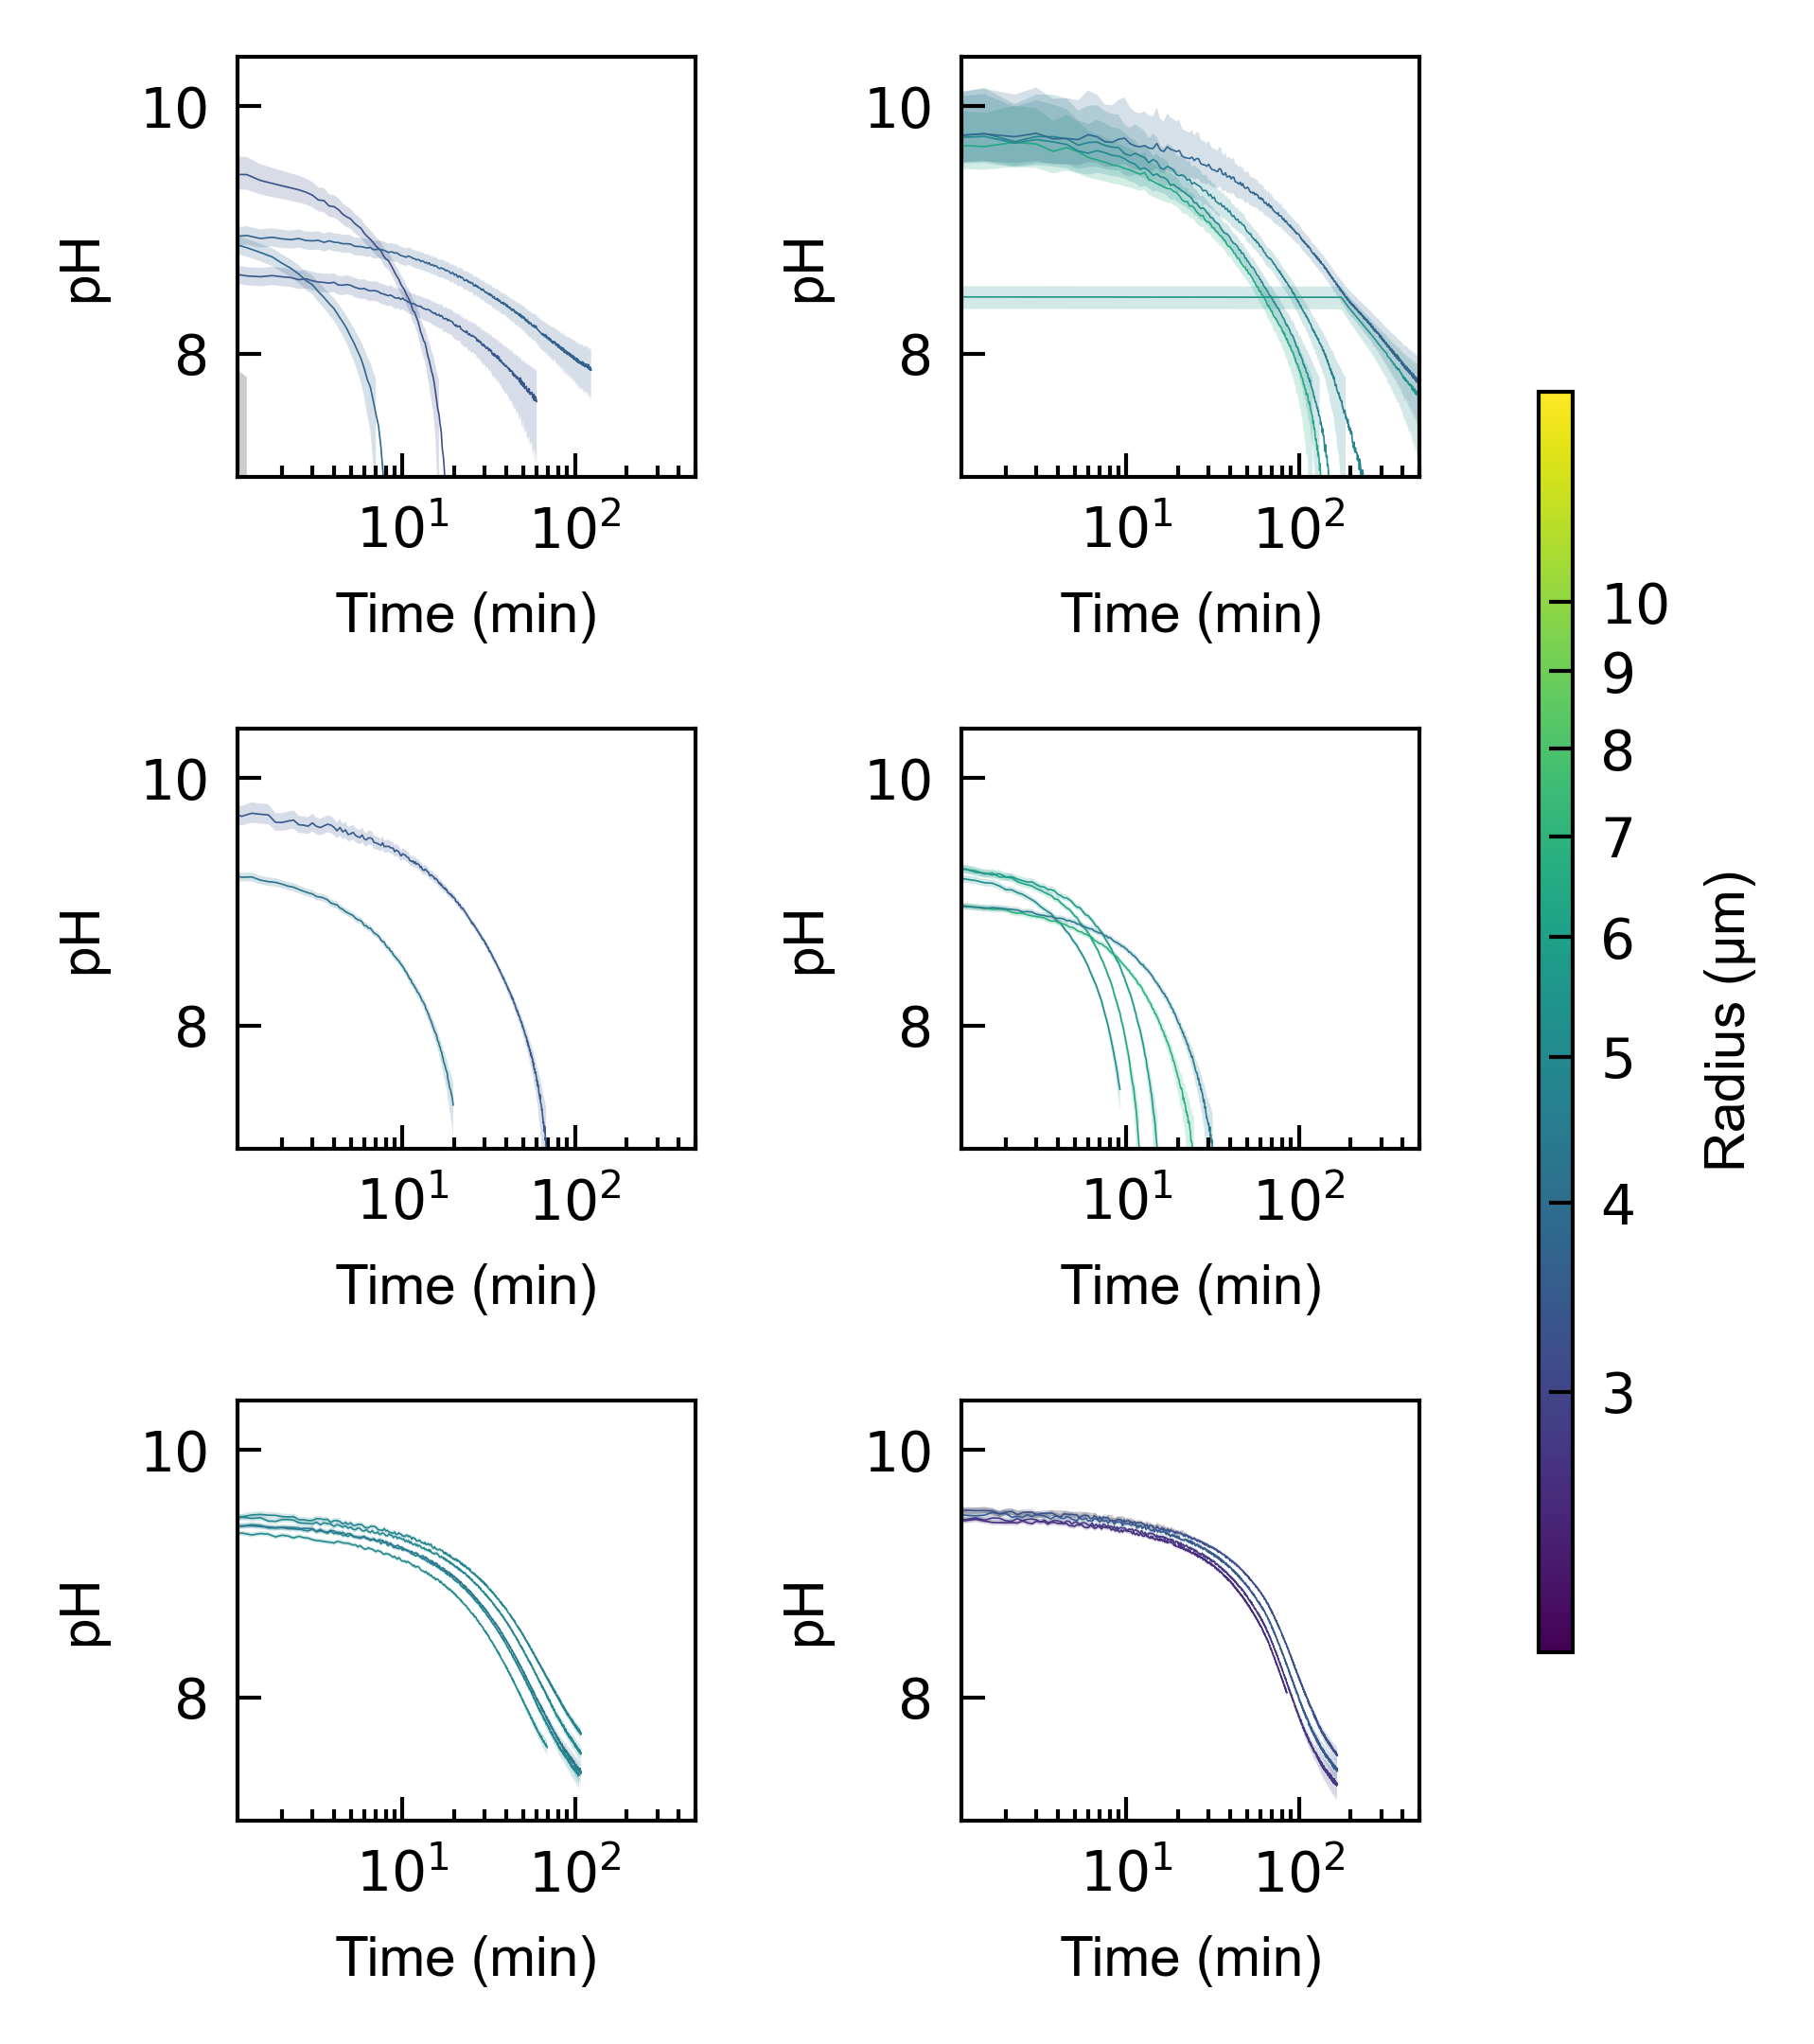

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define fixed figure dimensions
fixed_width = 3
tentative_height = 1.1 * 3 + 0.2 * 2

# Use LogNorm for color normalization
norm = LogNorm(vmin=combined_df['radius_ref_pH'].min(), vmax=combined_df['radius_ref_pH'].max())
cmap = plt.cm.viridis

# Create a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(fixed_width, tentative_height), dpi=600)
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for idx, exp in enumerate(experiments):
    selected_experiments = [exp]
    filtered_data = combined_df[combined_df['exp_date'].isin(selected_experiments)]

    # Compute rate parameters for each particle
    rate_parameters = {}
    for particle_ID in filtered_data['particle'].unique():
        data = filtered_data[filtered_data['particle'] == particle_ID]
        
        # Ensure data is non-empty and has at least two valid points
        valid_data = data[np.isfinite(data['pH']) & np.isfinite(data['time(sec)'])]
        if len(valid_data) > 1:
            first_pH, first_time = valid_data['pH'].iloc[0], valid_data['time(sec)'].iloc[0]
            last_pH, last_time = valid_data['pH'].iloc[-1], valid_data['time(sec)'].iloc[-1]
            
            rate_param = (last_pH - first_pH) / (last_time - first_time)
            if np.isfinite(rate_param):
                rate_parameters[particle_ID] = rate_param

    print(f"Total valid particles in experiment {exp}: {len(rate_parameters)}")

    # Convert rate parameters to a DataFrame
    rate_df = pd.DataFrame({
        'particle': list(rate_parameters.keys()),
        'rate_parameter': list(rate_parameters.values())
    })

    # Sort by rate_parameter
    rate_df = rate_df.sort_values(by='rate_parameter').reset_index(drop=True)
    print(rate_df)




    # Select 10 trajectories: slowest, fastest, and 8 evenly spaced ones in between
    if len(rate_df) >= 5:
        selected_indices = np.linspace(0, len(rate_df) - 1, num=5, dtype=int)  # Select indices evenly spaced
    else:
        selected_indices = np.arange(len(rate_df))  # If fewer than 10, take all available

    selected_particles = rate_df.iloc[selected_indices]['particle'].values

    # Filter data for selected particles
    selected_data = filtered_data[filtered_data['particle'].isin(selected_particles)]

    print(f"Selected particles for experiment {exp}: {selected_particles}")

    ax = axes[idx]

    # Plot lines for the selected particles
    for particle_ID in selected_particles:
        data = selected_data[selected_data['particle'] == particle_ID]
        color = cmap(norm(data['radius_ref_pH'].values[0]))
        time_min = (data['time(sec)'] - data['time(sec)'].values[0]) / 60  # Convert time to minutes

        if idx == 1:
            ax.fill_between(time_min.iloc[::3], data['pHhigh'].iloc[::3], data['pHlow'].iloc[::3], color=color, alpha=0.2, ec='none')
            ax.plot(time_min.iloc[::3], data['pH'].iloc[::3], color=color, label=f'Particle {particle_ID}', linewidth=0.2)
        else:
            ax.fill_between(time_min, data['pHhigh'], data['pHlow'], color=color, alpha=0.2, ec='none')
            ax.plot(time_min, data['pH'], color=color, label=f'Particle {particle_ID}', linewidth=0.2)

    # Label axes
    ax.set_xlabel('Time (min)', fontsize=7, fontname="Arial")
    ax.set_ylabel('pH', fontsize=7, fontname="Arial")
    ax.set_ylim([7, 10.4])
    ax.set_xlim([1.1, 5e2])
    ax.tick_params(axis='both', which='both', direction='in', labelsize=7)
    ax.set_xscale('log')

# Create a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'Radius ($\mathregular{\mu m}$)', fontsize=7, fontname="Arial")

# Define custom ticks and labels
custom_ticks = [3, 4, 5, 6, 7, 8, 9, 10]
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels([str(tick) for tick in custom_ticks])

# Customize colorbar tick font size
cbar.ax.tick_params(labelsize=7, direction='in', length=3)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


Total valid particles in experiment 23.11.14-15: 232
Selected particles for experiment 23.11.14-15: [np.float64(312.0), np.float64(217.0), np.float64(170.0), np.float64(283.0)]
Total valid particles in experiment 23.12.22-23: 37
Selected particles for experiment 23.12.22-23: [np.float64(371.0), np.float64(369.0), np.float64(394.0), np.float64(379.0)]
Total valid particles in experiment 24.04.01: 108
Selected particles for experiment 24.04.01: [np.float64(449.0), np.float64(474.0), np.float64(435.0), np.float64(414.0)]
Total valid particles in experiment 24.07.08: 95
Selected particles for experiment 24.07.08: [np.float64(620.0), np.float64(585.0), np.float64(555.0), np.float64(612.0)]
Total valid particles in experiment 24.11.09: 32
Selected particles for experiment 24.11.09: [np.float64(672.0), np.float64(658.0), np.float64(651.0), np.float64(648.0)]
Total valid particles in experiment 24.11.14: 152
Selected particles for experiment 24.11.14: [np.float64(705.0), np.float64(770.0), np.

/tmp/ipykernel_13006/2385529596.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


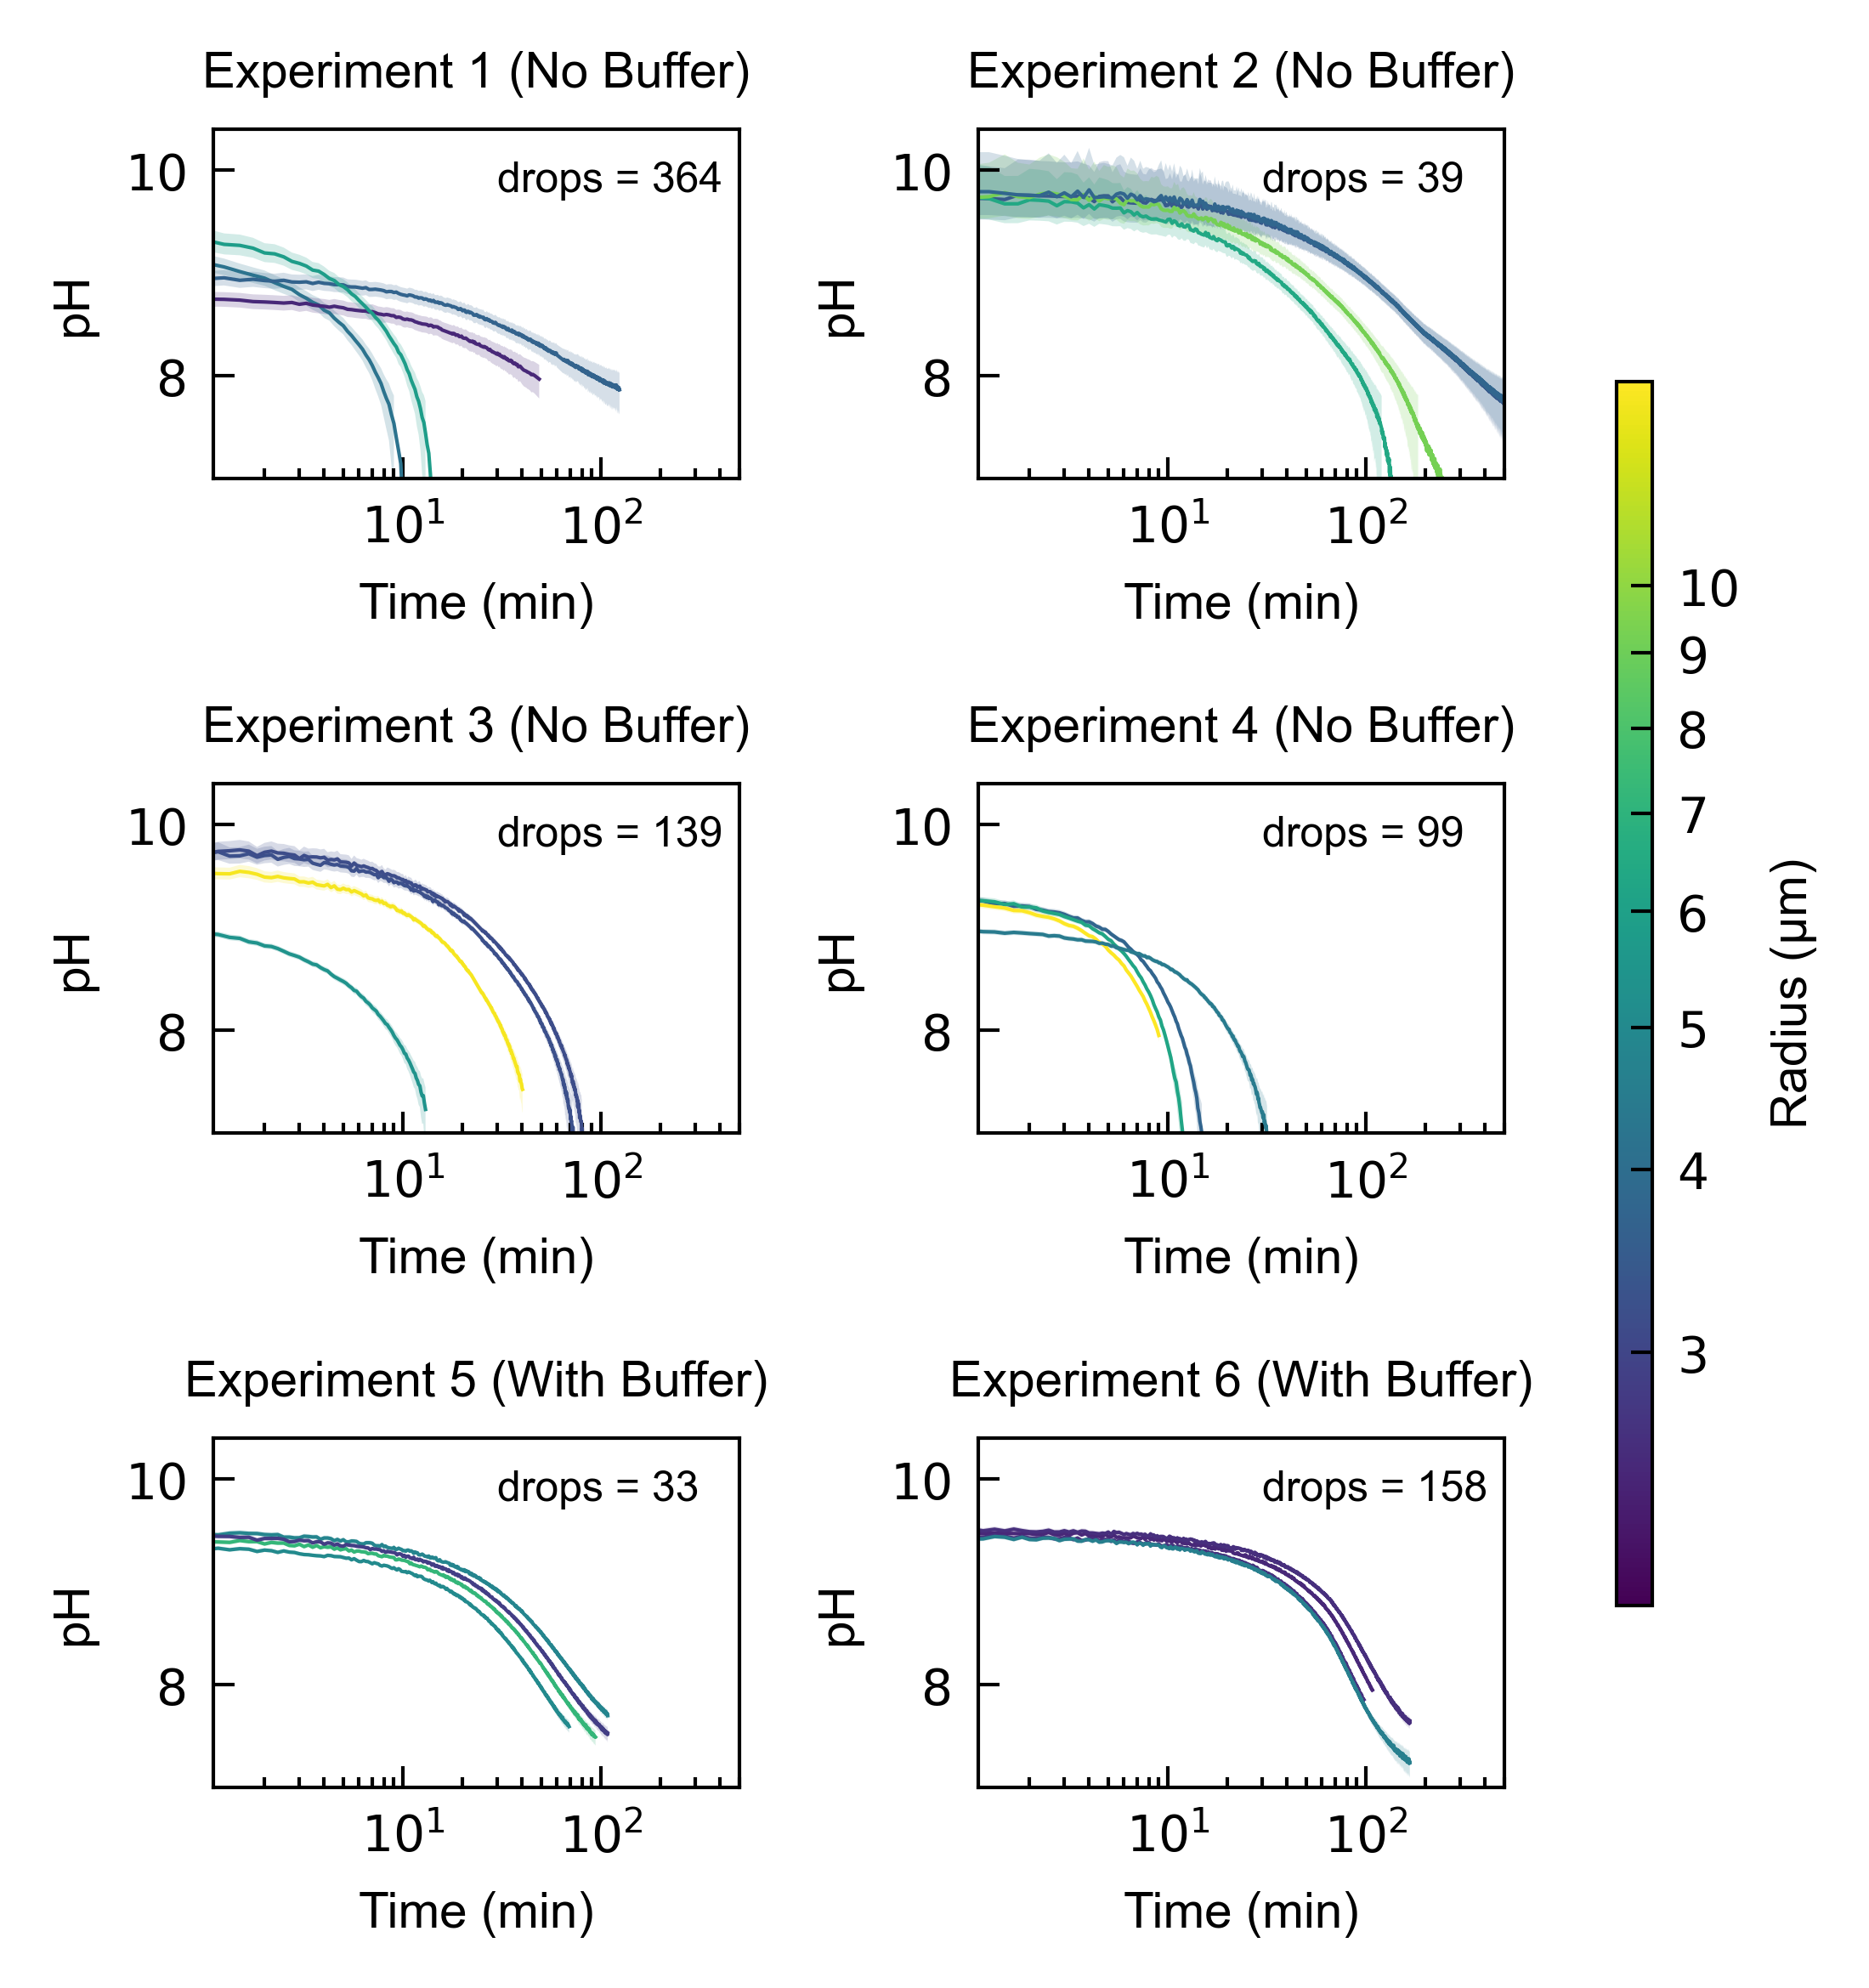

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define fixed figure dimensions
fixed_width = 3.5
tentative_height = 1.2 * 3 + 0.2 * 2

# Use LogNorm for color normalization
norm = LogNorm(vmin=combined_df['radius_ref_pH'].min(), vmax=combined_df['radius_ref_pH'].max())
cmap = plt.cm.viridis

# Create a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(fixed_width, tentative_height), dpi=600)
axes = axes.flatten()

for idx, exp in enumerate(experiments):
    selected_experiments = [exp]
    filtered_data = combined_df[combined_df['exp_date'].isin(selected_experiments)]

    # Compute rate parameters for each particle
    rate_parameters = {}
    radius_values = {}

    for particle_ID in filtered_data['particle'].unique():
        data = filtered_data[filtered_data['particle'] == particle_ID]
        
        # Ensure data is non-empty and has at least two valid points
        valid_data = data[np.isfinite(data['pH']) & np.isfinite(data['time(sec)'])]
        if len(valid_data) > 40 and valid_data['pH'].iloc[-1]<8:
            first_pH, first_time = valid_data['pH'].iloc[0], valid_data['time(sec)'].iloc[0]
            last_pH, last_time = valid_data['pH'].iloc[-1], valid_data['time(sec)'].iloc[-1]
            
            rate_param = (last_pH - first_pH) / (last_time - first_time)
            if np.isfinite(rate_param):
                rate_parameters[particle_ID] = rate_param

            # Store max radius_ref_pH value for each particle
            radius_values[particle_ID] = valid_data['radius_ref_pH'].max()

    print(f"Total valid particles in experiment {exp}: {len(rate_parameters)}")

    # Convert rate parameters to DataFrame
    rate_df = pd.DataFrame({
        'particle': list(rate_parameters.keys()),
        'rate_parameter': list(rate_parameters.values()),
        'radius_ref_pH': [radius_values[p] for p in rate_parameters.keys()]
    })

    # Remove rows where either rate_parameter or radius_ref_pH is NaN
    rate_df = rate_df.dropna(subset=['rate_parameter', 'radius_ref_pH'])

    # Sort by rate_parameter to get the fastest and slowest trajectories
    rate_df = rate_df.sort_values(by='rate_parameter').reset_index(drop=True)

    # Select key trajectories ensuring non-NaN values
    selected_particles = set()
    if len(rate_df) > 0:
        selected_particles.add(rate_df.iloc[0]['particle'])  # Slowest
        selected_particles.add(rate_df.iloc[-1]['particle'])  # Fastest

    # Sort by radius_ref_pH to get the smallest and largest radius
    radius_df = rate_df.sort_values(by='radius_ref_pH').reset_index(drop=True)
    if len(radius_df) > 0:
        selected_particles.add(radius_df.iloc[0]['particle'])  # Smallest radius
        selected_particles.add(radius_df.iloc[-1]['particle'])  # Largest radius


    selected_particles = list(selected_particles)

    # Filter data for selected particles
    selected_data = filtered_data[filtered_data['particle'].isin(selected_particles)]

    print(f"Selected particles for experiment {exp}: {selected_particles}")

    ax = axes[idx]

    # Plot lines for the selected particles
    for particle_ID in selected_particles:
        data = selected_data[selected_data['particle'] == int(particle_ID)]
        color = cmap(norm(data['radius_ref_pH'].values[0]))
        time_min = (data['time(sec)'] - data['time(sec)'].values[0]) / 60  # Convert time to minutes

        ax.fill_between(time_min, data['pHhigh'], data['pHlow'], color=color, alpha=0.2, ec='none')
        ax.plot(time_min, data['pH'], color=color, label=f'Particle {particle_ID}', linewidth=0.5)

    # Label axes
    ax.set_xlabel('Time (min)', fontsize=7, fontname="Arial")
    ax.set_ylabel('pH', fontsize=7, fontname="Arial")
    ax.set_ylim([7, 10.4])
    ax.set_xlim([1.1, 5e2])
    ax.tick_params(axis='both', which='both', direction='in', labelsize=7)
    ax.set_xscale('log')

    if idx in [0,1,2,3]:
        ax.set_title(f'Experiment {idx+1} (No Buffer)', fontsize=7, fontname="Arial")
        ax.text(3e1, 9.8, f"drops = {len(filtered_data['particle'].unique())}", fontsize=6, fontname="Arial")
    else:
        ax.set_title(f'Experiment {idx+1} (With Buffer)', fontsize=7, fontname="Arial")
        ax.text(3e1, 9.8, f"drops = {len(filtered_data['particle'].unique())}", fontsize=6, fontname="Arial")

        


# Create a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'Radius ($\mathregular{\mu m}$)', fontsize=7, fontname="Arial")


# Define custom ticks and labels
custom_ticks = [3, 4, 5, 6, 7, 8, 9, 10]
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels([str(tick) for tick in custom_ticks])

# Customize colorbar tick font size
cbar.ax.tick_params(labelsize=7, direction='in', length=3)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])

# plt.tight_layout(pad=0.5)

current_width, current_height = fig.get_size_inches()
scaling_factor = fixed_width/current_width
fig.set_size_inches(fixed_width, current_height*scaling_factor)

plt.savefig('SI figure pH profiles.svg', format='svg', bbox_inches="tight")
plt.savefig('SI figure pH profiles.pdf', format='pdf', bbox_inches="tight")
plt.savefig('SI figure pH profiles.png', format='png', bbox_inches="tight")


In [30]:
filtered_data

,particle,x,time(sec),pH,pHlow,pHhigh,delta,epsilon,vacuole,radius,...,vsignal,trackID,f_location,particleID_original,exp_date,radius_ref_pH,t0_ref_pH,consider_drop,min_pH,pH_sigma
131054,542,1784.956284,0.0,8.974027,8.948792,8.999320,0.519577,0.014517,0.0,4.289941,...,0.129501,24.09.23 updating pH calibration v3 for drops ...,7,1,24.07.08,4.220641,591.722505,1,5.463745,0.025264
131055,542,1786.050761,10.0,8.979090,8.953788,9.004459,0.522487,0.014551,0.0,4.272616,...,0.153194,24.09.23 updating pH calibration v3 for drops ...,7,1,24.07.08,4.220641,591.722505,1,5.463745,0.025335
131056,542,1787.946809,20.0,8.974629,8.949387,8.999931,0.519924,0.014521,0.0,4.289941,...,0.144616,24.09.23 updating pH calibration v3 for drops ...,7,1,24.07.08,4.220641,591.722505,1,5.463745,0.025272
131057,542,1788.027778,30.0,8.969917,8.944738,8.995146,0.517215,0.014487,0.0,4.289941,...,0.145168,24.09.23 updating pH calibration v3 for drops ...,7,1,24.07.08,4.220641,591.722505,1,5.463745,0.025204
131058,542,1788.057895,40.0,8.963376,8.938283,8.988509,0.513453,0.014442,0.0,4.289941,...,0.185061,24.09.23 updating pH calibration v3 for drops ...,7,1,24.07.08,4.220641,591.722505,1,5.463745,0.025113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140716,640,1084.008499,950.0,7.553633,7.416984,7.659426,0.039459,0.010342,1.0,10.319047,...,0.846217,24.09.23 updating pH calibration v3 for drops ...,2,12,24.07.08,7.479091,670.388665,1,7.370045,0.120235
140717,640,1084.965404,960.0,7.497464,7.340392,7.614751,0.034839,0.010314,1.0,10.388347,...,0.991127,24.09.23 updating pH calibration v3 for drops ...,2,12,24.07.08,7.479091,670.388665,1,7.370045,0.135730
140718,640,1084.991482,970.0,7.446891,7.267985,7.575578,0.031128,0.010291,1.0,10.440322,...,0.835485,24.09.23 updating pH calibration v3 for drops ...,2,12,24.07.08,7.479091,670.388665,1,7.370045,0.151733
140719,640,1085.972826,980.0,7.414198,7.219073,7.550812,0.028937,0.010277,1.0,10.526947,...,0.776095,24.09.23 updating pH calibration v3 for drops ...,2,12,24.07.08,7.479091,670.388665,1,7.370045,0.163270


/tmp/ipykernel_13006/4208280089.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


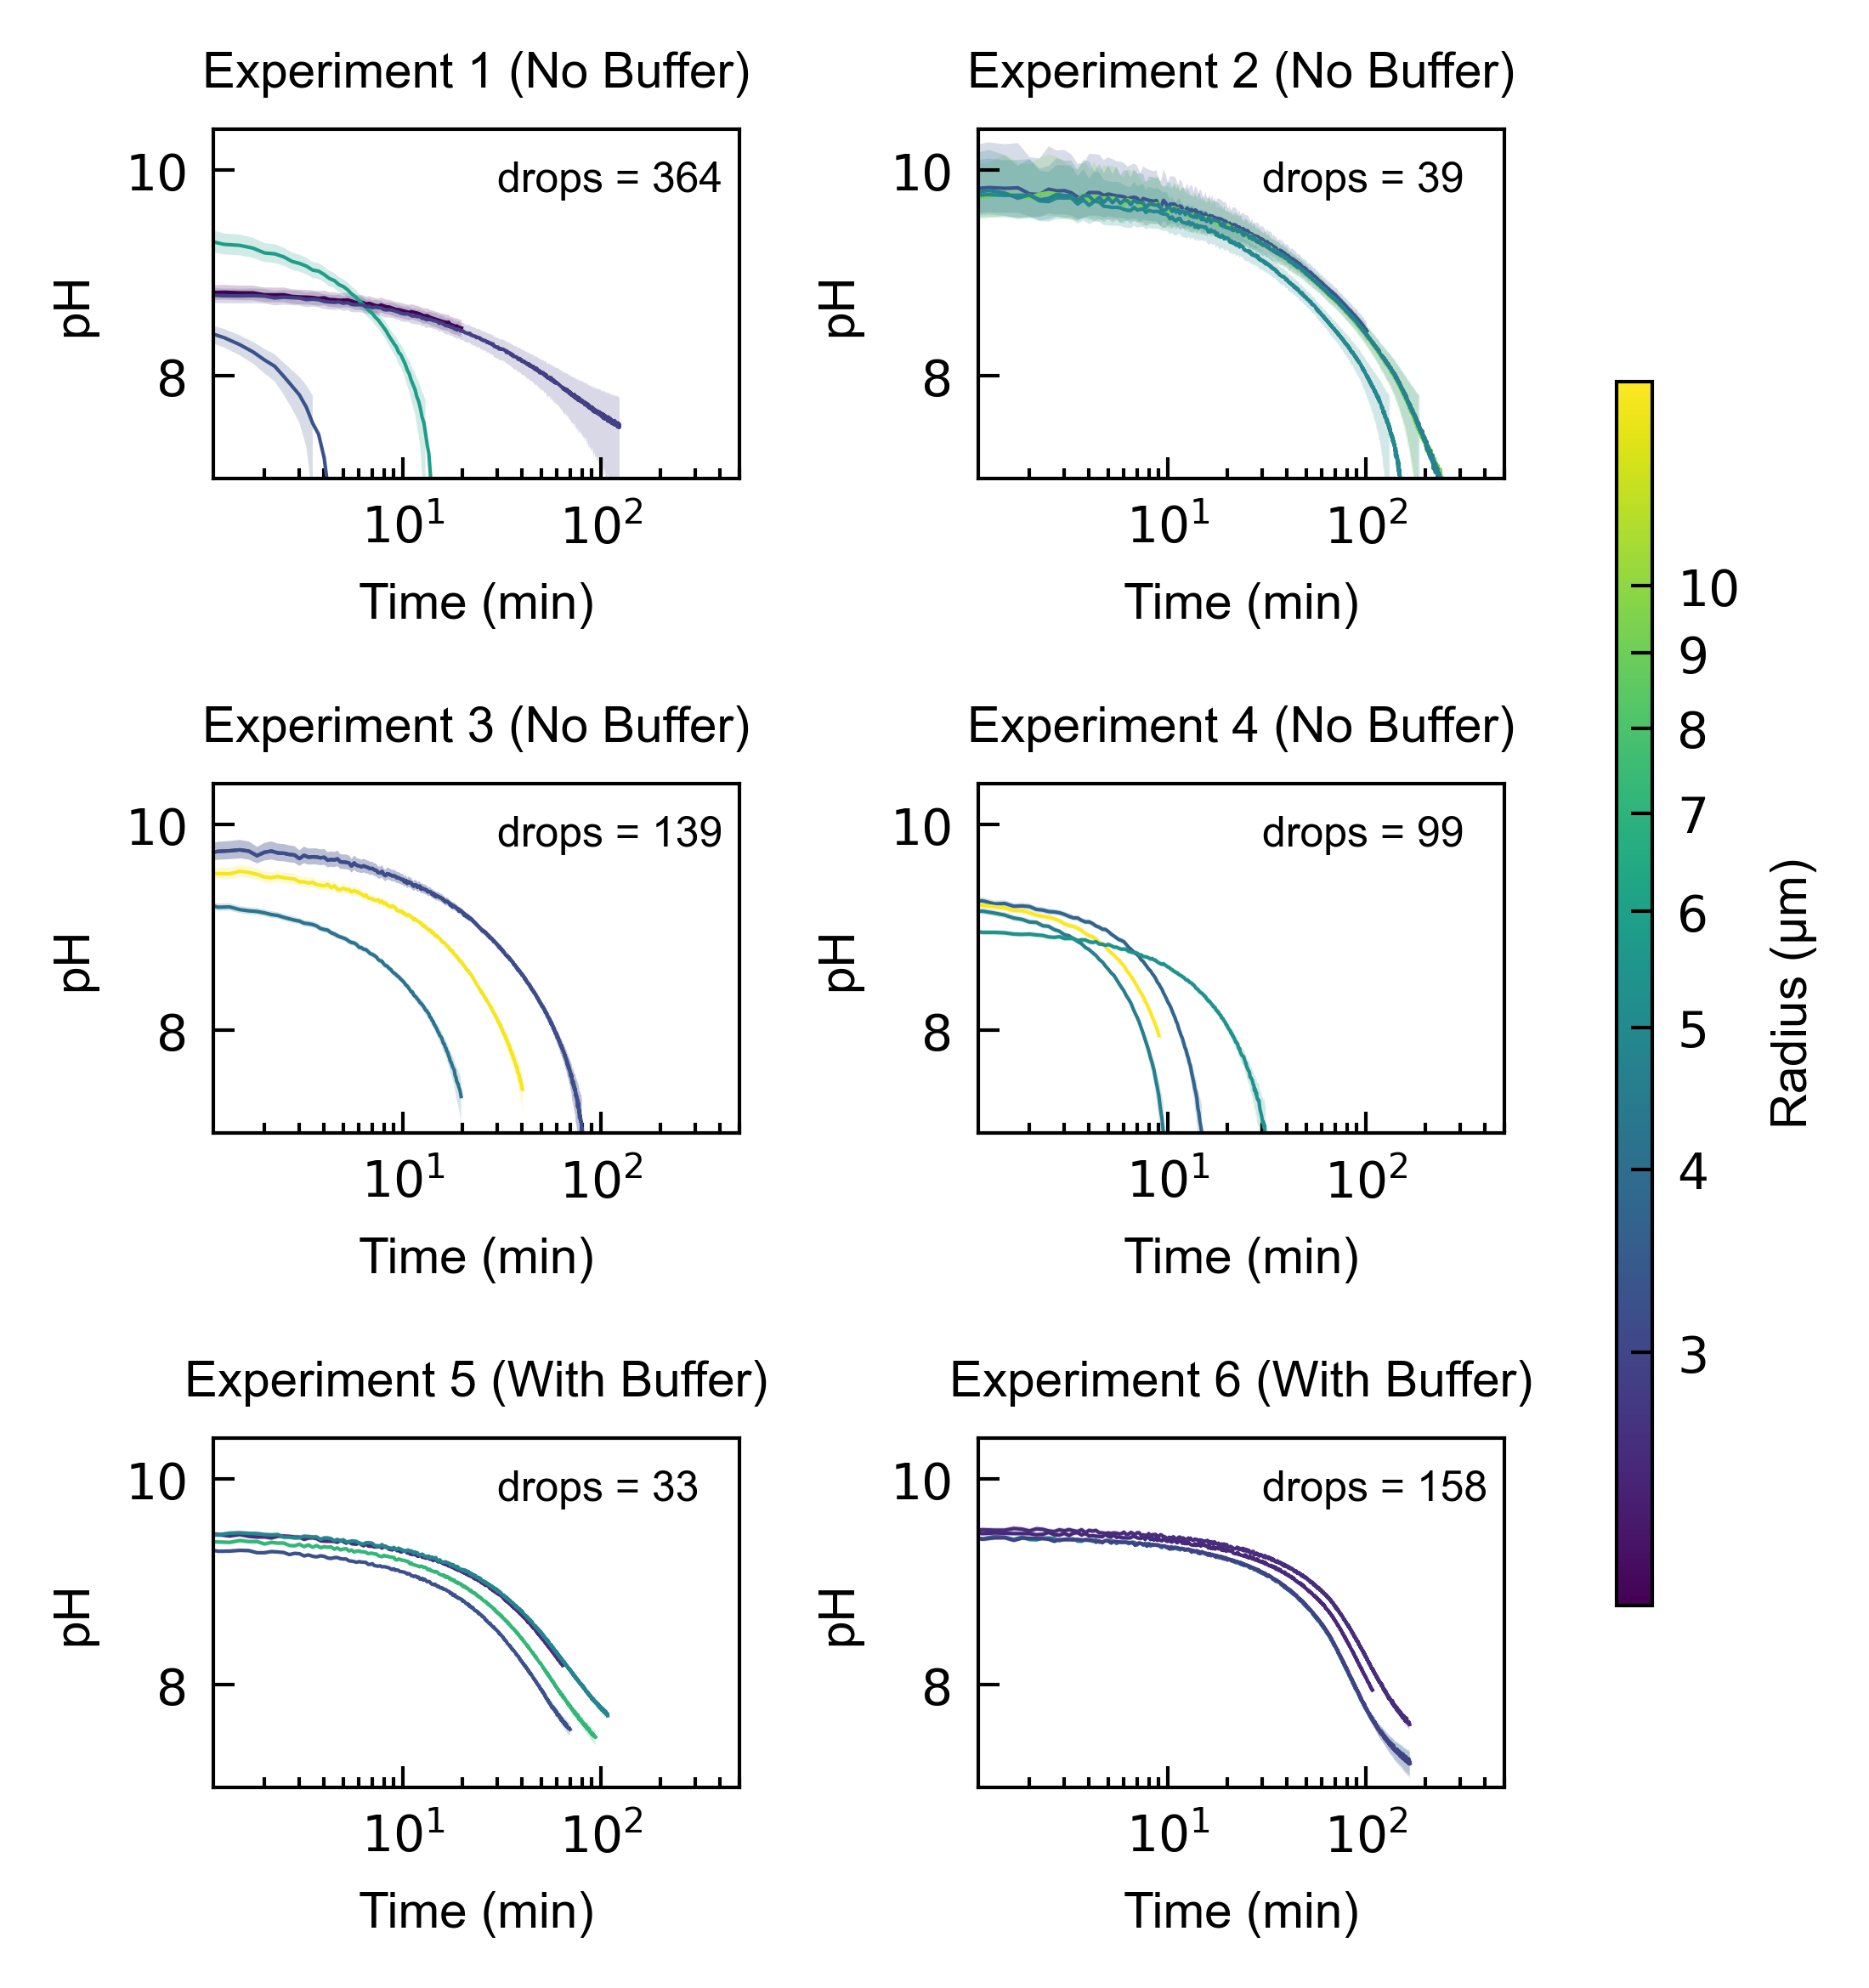

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define fixed figure dimensions
fixed_width = 3.5
tentative_height = 1.2 * 3 + 0.2 * 2

# Use LogNorm for color normalization
norm = LogNorm(vmin=combined_df['radius_ref_pH'].min(), vmax=combined_df['radius_ref_pH'].max())
cmap = plt.cm.viridis

# Create a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(fixed_width, tentative_height), dpi=600)
axes = axes.flatten()

ID = [[166,283,78,154],[399,394,368,395],[435,414,456,435],[620,555,553,617], [664, 651, 645, 672], [705, 719, 766, 785]]


for idx, exp in enumerate(experiments):
    selected_experiments = [exp]
    filtered_data = combined_df[combined_df['exp_date'].isin(selected_experiments)]

    ax = axes[idx]
    for j in range(4):
        data = filtered_data[filtered_data['particle'] == ID[idx][j]]
        color = cmap(norm(data['radius_ref_pH'].values[0]))
        time_min = (data['time(sec)'] - data['time(sec)'].values[0]) / 60  # Convert time to minutes
        ax.fill_between(time_min, data['pHhigh'], data['pHlow'], color=color, alpha=0.2, ec='none')
        ax.plot(time_min, data['pH'], color=color, label=f'Particle {particle_ID}', linewidth=0.5)


    # # Plot lines for the selected particles
    # for particle_ID in selected_particles:
    #     data = selected_data[selected_data['particle'] == int(particle_ID)]
    #     color = cmap(norm(data['radius_ref_pH'].values[0]))
    #     time_min = (data['time(sec)'] - data['time(sec)'].values[0]) / 60  # Convert time to minutes

    #     ax.fill_between(time_min, data['pHhigh'], data['pHlow'], color=color, alpha=0.2, ec='none')
    #     ax.plot(time_min, data['pH'], color=color, label=f'Particle {particle_ID}', linewidth=0.5)

    # Label axes
    ax.set_xlabel('Time (min)', fontsize=7, fontname="Arial")
    ax.set_ylabel('pH', fontsize=7, fontname="Arial")
    ax.set_ylim([7, 10.4])
    ax.set_xlim([1.1, 5e2])
    ax.tick_params(axis='both', which='both', direction='in', labelsize=7)
    ax.set_xscale('log')

    if idx in [0,1,2,3]:
        ax.set_title(f'Experiment {idx+1} (No Buffer)', fontsize=7, fontname="Arial")
        ax.text(3e1, 9.8, f"drops = {len(filtered_data['particle'].unique())}", fontsize=6, fontname="Arial")
    else:
        ax.set_title(f'Experiment {idx+1} (With Buffer)', fontsize=7, fontname="Arial")
        ax.text(3e1, 9.8, f"drops = {len(filtered_data['particle'].unique())}", fontsize=6, fontname="Arial")


# Create a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'Radius ($\mathregular{\mu m}$)', fontsize=7, fontname="Arial")


# Define custom ticks and labels
custom_ticks = [3, 4, 5, 6, 7, 8, 9, 10]
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels([str(tick) for tick in custom_ticks])

# Customize colorbar tick font size
cbar.ax.tick_params(labelsize=7, direction='in', length=3)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])

# plt.tight_layout(pad=0.5)

current_width, current_height = fig.get_size_inches()
scaling_factor = fixed_width/current_width
fig.set_size_inches(fixed_width, current_height*scaling_factor)

plt.savefig('SI figure pH profiles.svg', format='svg', bbox_inches="tight")
plt.savefig('SI figure pH profiles.pdf', format='pdf', bbox_inches="tight")
plt.savefig('SI figure pH profiles.png', format='png', bbox_inches="tight")


Total valid particles in experiment 24.11.09: 32
Selected particles for experiment 24.11.09: [np.float64(672.0), np.float64(658.0), np.float64(651.0), np.float64(648.0)]
Total valid particles in experiment 24.11.14: 152
Selected particles for experiment 24.11.14: [np.float64(705.0), np.float64(770.0), np.float64(803.0), np.float64(719.0)]


/tmp/ipykernel_129789/3386530550.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


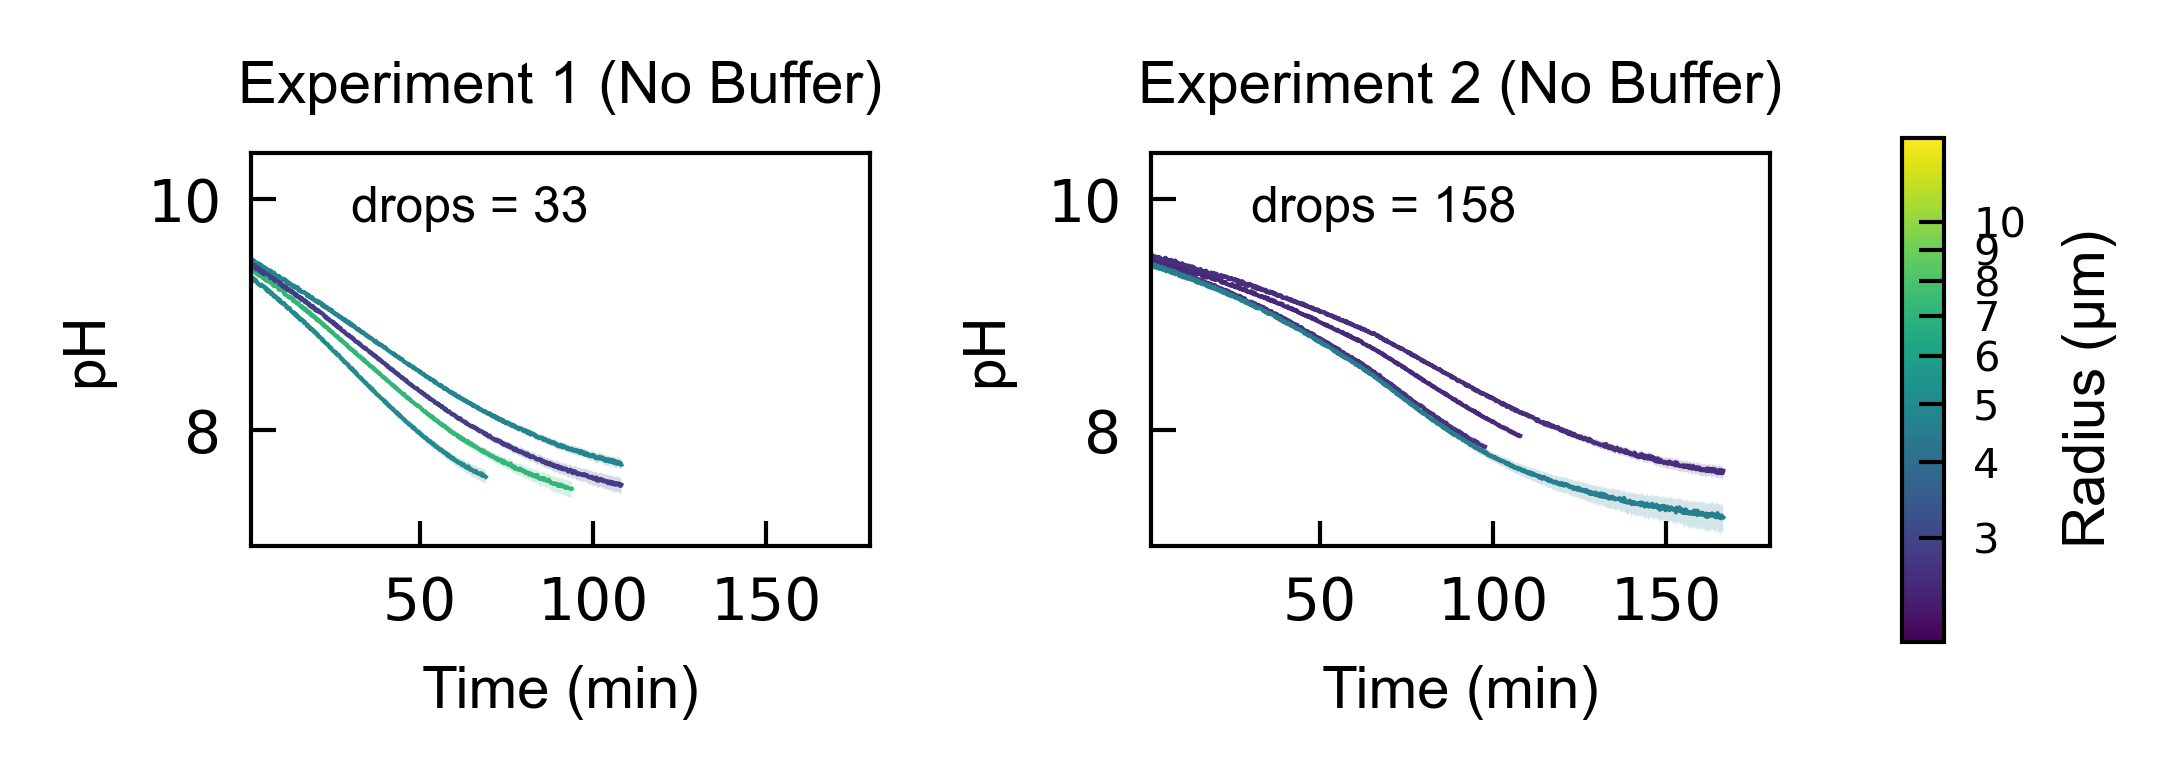

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define fixed figure dimensions
fixed_width = 3.5
tentative_height = 1.4

# Use LogNorm for color normalization
norm = LogNorm(vmin=combined_df['radius_ref_pH'].min(), vmax=combined_df['radius_ref_pH'].max())
cmap = plt.cm.viridis

# Create a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(fixed_width, tentative_height), dpi=600)
axes = axes.flatten()

for idx, exp in enumerate(asymptotic_exp):
    selected_experiments = [exp]
    filtered_data = combined_df[combined_df['exp_date'].isin(selected_experiments)]

    # Compute rate parameters for each particle
    rate_parameters = {}
    radius_values = {}

    for particle_ID in filtered_data['particle'].unique():
        data = filtered_data[filtered_data['particle'] == particle_ID]
        
        # Ensure data is non-empty and has at least two valid points
        valid_data = data[np.isfinite(data['pH']) & np.isfinite(data['time(sec)'])]
        if len(valid_data) > 40 and valid_data['pH'].iloc[-1]<8:
            first_pH, first_time = valid_data['pH'].iloc[0], valid_data['time(sec)'].iloc[0]
            last_pH, last_time = valid_data['pH'].iloc[-1], valid_data['time(sec)'].iloc[-1]
            
            rate_param = (last_pH - first_pH) / (last_time - first_time)
            if np.isfinite(rate_param):
                rate_parameters[particle_ID] = rate_param

            # Store max radius_ref_pH value for each particle
            radius_values[particle_ID] = valid_data['radius_ref_pH'].max()

    print(f"Total valid particles in experiment {exp}: {len(rate_parameters)}")

    # Convert rate parameters to DataFrame
    rate_df = pd.DataFrame({
        'particle': list(rate_parameters.keys()),
        'rate_parameter': list(rate_parameters.values()),
        'radius_ref_pH': [radius_values[p] for p in rate_parameters.keys()]
    })

    # Remove rows where either rate_parameter or radius_ref_pH is NaN
    rate_df = rate_df.dropna(subset=['rate_parameter', 'radius_ref_pH'])

    # Sort by rate_parameter to get the fastest and slowest trajectories
    rate_df = rate_df.sort_values(by='rate_parameter').reset_index(drop=True)

    # Select key trajectories ensuring non-NaN values
    selected_particles = set()
    if len(rate_df) > 0:
        selected_particles.add(rate_df.iloc[0]['particle'])  # Slowest
        selected_particles.add(rate_df.iloc[-1]['particle'])  # Fastest

    # Sort by radius_ref_pH to get the smallest and largest radius
    radius_df = rate_df.sort_values(by='radius_ref_pH').reset_index(drop=True)
    if len(radius_df) > 0:
        selected_particles.add(radius_df.iloc[0]['particle'])  # Smallest radius
        selected_particles.add(radius_df.iloc[-1]['particle'])  # Largest radius


    selected_particles = list(selected_particles)

    # Filter data for selected particles
    selected_data = filtered_data[filtered_data['particle'].isin(selected_particles)]

    print(f"Selected particles for experiment {exp}: {selected_particles}")

    ax = axes[idx]

    # Plot lines for the selected particles
    for particle_ID in selected_particles:
        data = selected_data[selected_data['particle'] == int(particle_ID)]
        color = cmap(norm(data['radius_ref_pH'].values[0]))
        time_min = (data['time(sec)'] - data['time(sec)'].values[0]) / 60  # Convert time to minutes

        ax.fill_between(time_min, data['pHhigh'], data['pHlow'], color=color, alpha=0.2, ec='none')
        ax.plot(time_min, data['pH'], color=color, label=f'Particle {particle_ID}', linewidth=0.5)

    # Label axes
    ax.set_xlabel('Time (min)', fontsize=7, fontname="Arial")
    ax.set_ylabel('pH', fontsize=7, fontname="Arial")
    ax.set_ylim([7, 10.4])
    ax.set_xlim([1.1, 180])
    ax.tick_params(axis='both', which='both', direction='in', labelsize=7)
    # ax.set_xscale('log')

    if idx in [0,1,2,3]:
        ax.set_title(f'Experiment {idx+1} (No Buffer)', fontsize=7, fontname="Arial")
        ax.text(3e1, 9.8, f"drops = {len(filtered_data['particle'].unique())}", fontsize=6, fontname="Arial")
    else:
        ax.set_title(f'Experiment {idx+1} (With Buffer)', fontsize=7, fontname="Arial")
        ax.text(3e1, 9.8, f"drops = {len(filtered_data['particle'].unique())}", fontsize=6, fontname="Arial")

        


# Create a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'Radius ($\mathregular{\mu m}$)', fontsize=7, fontname="Arial")


# Define custom ticks and labels
custom_ticks = [3, 4, 5, 6, 7, 8, 9, 10]
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels([str(tick) for tick in custom_ticks])

# Customize colorbar tick font size
cbar.ax.tick_params(labelsize=5, direction='in', length=3)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])

# plt.tight_layout(pad=0.5)

current_width, current_height = fig.get_size_inches()
scaling_factor = fixed_width/current_width
fig.set_size_inches(fixed_width, current_height*scaling_factor)

plt.savefig('asym profile for Jane.svg', format='svg', bbox_inches="tight")
